<a href="https://colab.research.google.com/github/pscabral/IFMASOFTEX_1/blob/main/Yolo8_v1.8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mega.py

from mega import Mega

# Crie uma instância da classe Mega
mega = Mega()

# Cole o link completo do Mega.nz (incluindo a chave)
url = "https://mega.nz/file/gzcmkBbS#Xo0iwU47Ffld8w4sqtNYtDkjh5vmSud05X_xqLEjVGw"

# Use o link completo para fazer o download
mega.download_url(url)

!unzip Comida2.0.v1i.yolov8.zip -d comida2.0.v1i

In [ ]:
!pip install ultralytics

In [ ]:
!pip install albumentations

In [4]:
import os
import random
import shutil
from pathlib import Path

import torch
import torch.nn as nn

import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
import warnings
import glob
import albumentations as A
import matplotlib.pyplot as plt
from shutil import copyfile
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [ ]:
def transformer(image_folder_path, annotation_folder_path):
    image_folder = Path(image_folder_path)
    annotation_folder = Path(annotation_folder_path)

    for image_path in image_folder.glob('**/*.jpg'):
        image_name = image_path.stem
        relative_label_path = image_path.relative_to(image_folder).with_suffix('.txt')
        label_path = annotation_folder / relative_label_path

        try:
            print(f'Processando: {image_name}')

            if not label_path.exists():
                print(f'Aviso: O arquivo de anotação não existe para {image_name}')
                continue

            horizontal_flip(image_path, label_path, image_name)
            vertical_flip(image_path, label_path, image_name)

            print(f'{image_name} processado com sucesso')

        except Exception as e:
            print(f'Falhou: {image_name}. Erro: {e}')

def horizontal_flip(image_path, label_path, save_name):
    try:
        print(f'  Aplicando transformação horizontal para: {image_path}')

        image = cv2.imread(str(image_path))

        with open(label_path, 'r') as f:
            lines = f.readlines()

        bbox = []
        for line in lines:
            l = line.split(' ')
            bbox.append([float(l[1]), float(l[2]), float(l[3]), float(l[4]), str(l[0])])

        transform = A.Compose([A.HorizontalFlip()], bbox_params=A.BboxParams(format='yolo'))
        transformed = transform(image=image, bboxes=bbox)

        image_transformed = transformed['image']
        boxes = transformed['bboxes']

        save_image_path = image_path.parent / f'{save_name}_hf.jpg'
        cv2.imwrite(str(save_image_path), image_transformed)

        save_label_path = label_path.parent / f'{save_name}_hf.txt'
        with open(str(save_label_path), 'w') as f:
            for box in boxes:
                f.write(f"{box[-1]} {box[0]} {box[1]} {box[2]} {box[3]}\n")

        print(f'  Transformação concluída para: {image_path}')

    except Exception as e:
        raise RuntimeError(f'Falhou: {save_name}. Erro: {e}')

def vertical_flip(image_path, label_path, save_name):
    try:
        print(f'  Aplicando transformação vertical para: {image_path}')

        image = cv2.imread(str(image_path))

        with open(label_path, 'r') as f:
            lines = f.readlines()

        bbox = []
        for line in lines:
            l = line.split(' ')
            bbox.append([float(l[1]), float(l[2]), float(l[3]), float(l[4]), str(l[0])])

        transform = A.Compose([A.VerticalFlip()], bbox_params=A.BboxParams(format='yolo'))
        transformed = transform(image=image, bboxes=bbox)

        image_transformed = transformed['image']
        boxes = transformed['bboxes']

        save_image_path = image_path.parent / f'{save_name}_vf.jpg'
        cv2.imwrite(str(save_image_path), image_transformed)

        save_label_path = label_path.parent / f'{save_name}_vf.txt'
        with open(str(save_label_path), 'w') as f:
            for box in boxes:
                f.write(f"{box[-1]} {box[0]} {box[1]} {box[2]} {box[3]}\n")

        print(f'  Transformação concluída para: {image_path}')

    except Exception as e:
        raise RuntimeError(f'Falhou: {save_name}. Erro: {e}')

# Caminhos dos diretórios
image_folder_path = '/content/comida2.0.v1i/train/images'
annotation_folder_path = '/content/comida2.0.v1i/train/labels'

# Executar a transformação
transformer(image_folder_path, annotation_folder_path)


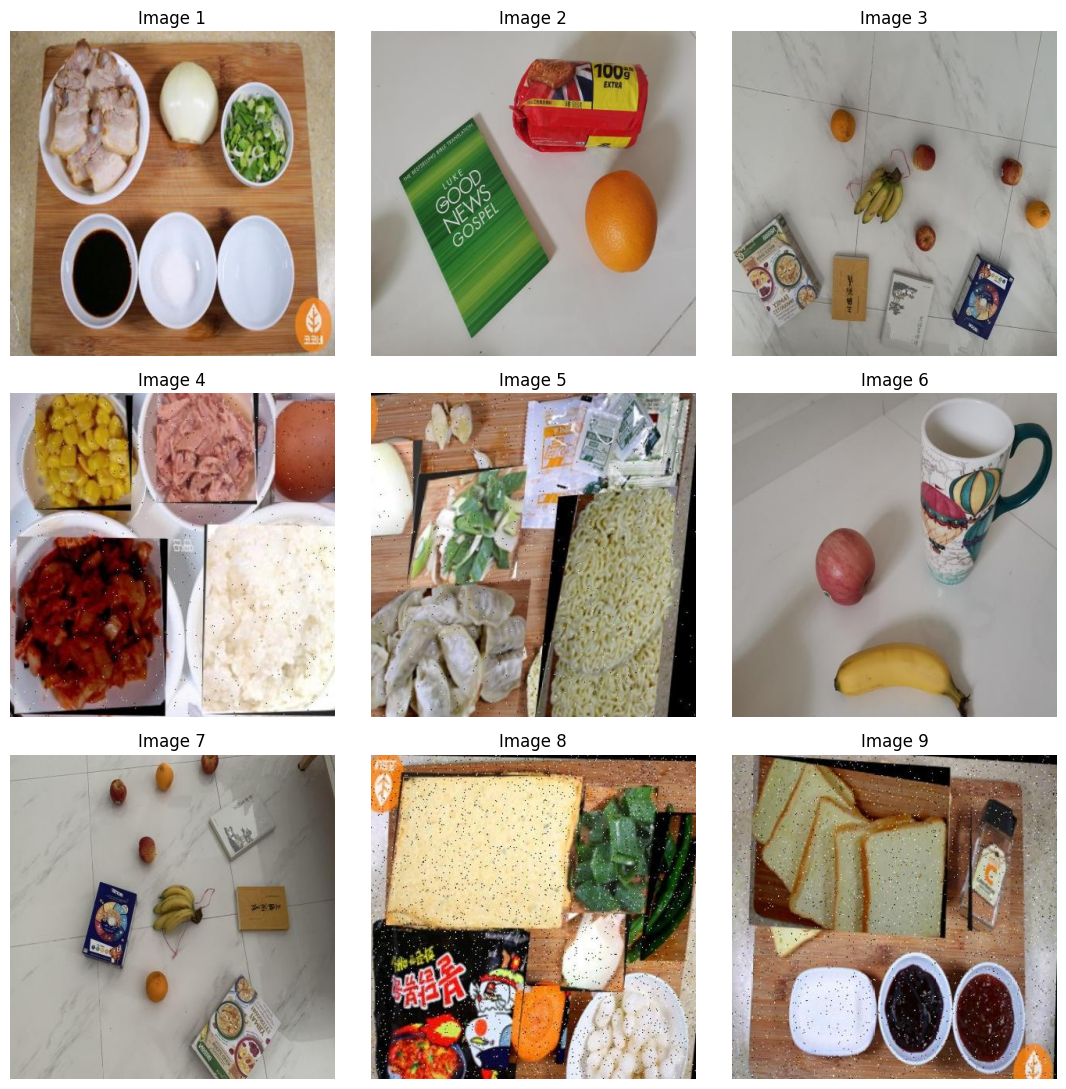

In [6]:
Image_dir = '/content/comida2.0.v1i/train/images'

num_samples = 9
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
image = cv2.imread("/content/comida2.0.v1i/train/images/----_jpg.rf.1ddba127dd12741bd457a0c82c39a155_hf.jpg")
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 416x416 and 3 channels.


100%|██████████| 21.5M/21.5M [00:00<00:00, 157MB/s]



image 1/1 /content/comida2.0.v1i/train/images/----_jpg.rf.1ddba127dd12741bd457a0c82c39a155_hf.jpg: 416x416 2 carrots, 3 cakes, 288.5ms
Speed: 4.3ms preprocess, 288.5ms inference, 34.9ms postprocess per image at shape (1, 3, 416, 416)


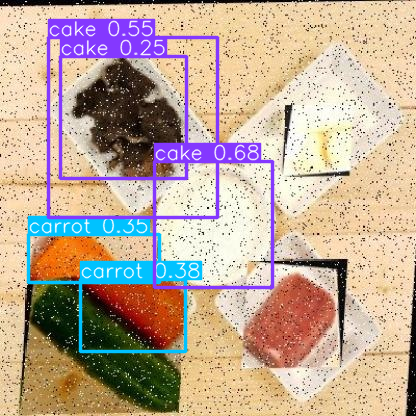

In [8]:
model = YOLO("yolov8s.pt")

# Use the model to detect object
image = "/content/comida2.0.v1i/train/images/----_jpg.rf.1ddba127dd12741bd457a0c82c39a155_hf.jpg"
result_predict = model.predict(source = image, imgsz=(416))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

In [9]:
Final_model = YOLO('yolov8s.pt')
Result_Final_model = Final_model.train(data="/content/comida2.0.v1i/data.yaml", epochs=10, patience=10, batch = 16, cache = True, imgsz=416, iou = 0.5, augment=True, degrees=25.0, fliplr=0.0, lr0=0.0001, optimizer='Adam')

Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/comida2.0.v1i/data.yaml, epochs=10, time=None, patience=10, batch=16, imgsz=416, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

100%|██████████| 755k/755k [00:00<00:00, 15.5MB/s]


Overriding model.yaml nc=80 with nc=90

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

train: Scanning /content/comida2.0.v1i/train/labels... 2673 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2673/2673 [00:02<00:00, 1322.00it/s]


train: New cache created: /content/comida2.0.v1i/train/labels.cache


train: Caching images (1.3GB True): 100%|██████████| 2673/2673 [00:01<00:00, 1548.63it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/comida2.0.v1i/valid/labels... 86 images, 0 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<00:00, 1214.16it/s]

val: New cache created: /content/comida2.0.v1i/valid/labels.cache



val: Caching images (0.0GB True): 100%|██████████| 86/86 [00:00<00:00, 1349.84it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.233      2.482      1.389          4        416: 100%|██████████| 168/168 [11:43<00:00,  4.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.06s/it]

                   all         86        394      0.706      0.204      0.242      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G       1.08      1.485      1.276          2        416: 100%|██████████| 168/168 [11:51<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.08s/it]

                   all         86        394      0.604      0.398      0.467      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      0.981      1.078      1.187          7        416: 100%|██████████| 168/168 [12:06<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.03s/it]

                   all         86        394      0.588      0.559      0.635      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.9316     0.8381       1.15          7        416: 100%|██████████| 168/168 [12:00<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.70s/it]

                   all         86        394      0.697      0.628      0.737      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      0.883     0.7279       1.12          5        416: 100%|██████████| 168/168 [11:39<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.81s/it]

                   all         86        394      0.661      0.691      0.753       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.8384     0.6633      1.104          1        416: 100%|██████████| 168/168 [11:33<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]

                   all         86        394      0.694      0.749       0.81      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.8067     0.6003       1.08          7        416: 100%|██████████| 168/168 [11:29<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.81s/it]

                   all         86        394        0.7       0.75      0.814      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.7795     0.5529      1.061          6        416: 100%|██████████| 168/168 [11:29<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:07<00:00,  2.63s/it]

                   all         86        394      0.736       0.77      0.828       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.7432     0.5122       1.04          4        416: 100%|██████████| 168/168 [11:31<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.83s/it]

                   all         86        394      0.725      0.767       0.83      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      0.728     0.4905      1.028          2        416: 100%|██████████| 168/168 [11:30<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:08<00:00,  2.82s/it]

                   all         86        394      0.827      0.707       0.83      0.648



10 epochs completed in 1.976 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11160414 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.05s/it]


                   all         86        394      0.787      0.751      0.834      0.631
                 Apple         86         66      0.969      0.985      0.995      0.758
                Banana         86         37      0.965          1      0.994      0.741
                  Book         86         23          1      0.993      0.995      0.865
             Cerealbox         86         24          1      0.899      0.961      0.797
             Kochujang         86          1      0.785          1      0.995      0.796
                Orange         86         26          1      0.976      0.995      0.787
                 bacon         86          3      0.854      0.667      0.736       0.51
                banana         86          4          1      0.491      0.594       0.52
                 bread         86         11      0.967      0.727      0.868      0.704
                butter         86          8      0.827       0.75      0.902      0.601
               cabbag

In [16]:
!yolo task=detect \
       mode=predict \
       model=/content/runs/detect/train/weights/best.pt \
       conf=0.25 \
       source='/content/comida2.0.v1i/valid/images/047_PNG_jpg.rf.9c701f12ecc8cbc9ddd5a7f948516272.jpg'

Ultralytics YOLOv8.0.238 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3243314 parameters, 0 gradients, 9.2 GFLOPs

image 1/1 /content/comida2.0.v1i/valid/images/047_PNG_jpg.rf.9c701f12ecc8cbc9ddd5a7f948516272.jpg: 416x416 1 dumpling, 1 egg, 85.0ms
Speed: 2.0ms preprocess, 85.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [17]:
class C2f(nn.Module):
    # CSP Bottleneck with 2 convolutions
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        self.c = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, 2 * self.c, 1, 1)
        self.cv2 = Conv((2 + n) * self.c, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.ModuleList(Bottleneck(self.c, self.c, shortcut, g, k=((3, 3), (3, 3)), e=1.0) for _ in range(n))

    def forward(self, x):
        # y = list(self.cv1(x).split((self.c, self.c), 1))
        # y.extend(m(y[-1]) for m in self.m)
        # return self.cv2(torch.cat(y, 1))

        print("ook")
        x = self.cv1(x)
        x = [x, x[:, self.c:, ...]]
        x.extend(m(x[-1]) for m in self.m)
        x.pop(1)
        return self.cv2(torch.cat(x, 1))

In [18]:
def forward(self, x):
        shape = x[0].shape  # BCHW
        for i in range(self.nl):
            x[i] = torch.cat((self.cv2[i](x[i]), self.cv3[i](x[i])), 1)
        if self.training:
            return x
        elif self.dynamic or self.shape != shape:
            self.anchors, self.strides = (x.transpose(0, 1) for x in make_anchors(x, self.stride, 0.5))
            self.shape = shape

        # box, cls = torch.cat([xi.view(shape[0], self.no, -1) for xi in x], 2).split((self.reg_max * 4, self.nc), 1)
        # dbox = dist2bbox(self.dfl(box), self.anchors.unsqueeze(0), xywh=True, dim=1) * self.strides
        # y = torch.cat((dbox, cls.sigmoid()), 1)
        # return y if self.export else (y, x)

        print("ook")
        return torch.cat([xi.view(shape[0], self.no, -1) for xi in x], 2).permute(0, 2, 1)

In [22]:
!yolo task=detect mode=export model=/content/runs/detect/train/weights/best.pt \
format=onnx simplify=True opset=13 imgsz=416

Ultralytics YOLOv8.0.238 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3243314 parameters, 0 gradients, 9.2 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 94, 3549) (6.4 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxsim>=0.4.33', 'onnxruntime'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 151.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 257.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 11.3s, installed 3 packages: ['onnx>=1.12.0', 'onnxsim>=0.4.33', 'onnxruntime']
requirements: ⚠️ Restart runtime or reru

In [ ]:
print('result of training')
tpaths2=[]
for dirname, _, filenames in os.walk('/content/runs/detect/train'):
    for filename in filenames:
        if filename[-4:]=='.png' or filename[-4:]=='.jpg':
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)
print(tpaths2[0])

result of training
/content/runs/detect/train/F1_curve.png


In [ ]:
for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()

In [ ]:
print('Predict')
best_path0='/content/runs/detect/train/weights/best.pt'
source0='/content/comida2.0.v1i/valid/images'

Predict


In [ ]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
print(ppaths[0])

/content/comida2.0.v1i/valid/images/007_jpg.rf.bdf4efdbad0d7ce195263e3c21856a27.jpg


In [ ]:
model2 = YOLO(best_path0)
print('yolo task=detect mode=predict')

yolo task=detect mode=predict


In [ ]:
!yolo task=detect mode=predict model={best_path0} conf=0.4 source={source0}

In [ ]:
print('Result of Prediction')
results = model2.predict(source0,conf=0.4)
print(len(results))

In [ ]:
PBOX=pd.DataFrame(columns=range(6))
for i in range(len(results)):
    arri=pd.DataFrame(results[i].boxes.data).astype(float)
    path=ppaths[i]
    file=path.split('/')[-1]
    arri=arri.assign(file=file)
    arri=arri.assign(i=i)
    PBOX=pd.concat([PBOX,arri],axis=0)
PBOX.columns=['x','y','x2','y2','confidence','class','file','i']
display(PBOX)

In [ ]:
class_map = {
    0: 'Maçã',
    1: 'Banana',
    2: 'Livro',
    3: 'Caixa de Cereal',
    4: 'Kochujang',
    5: 'Laranja',
    6: 'maçã',
    7: 'abacate',
    8: 'bacon',
    9: 'banana',
    10: 'carne bovina',
    11: 'pão',
    12: 'bardana',
    13: 'manteiga',
    14: 'repolho',
    15: 'milho enlatado',
    16: 'atum enlatado',
    17: 'cenoura',
    18: 'queijo',
    19: 'frango',
    20: 'pimenta em pó',
    21: 'pão de chocolate',
    22: 'canela',
    23: 'óleo de cozinha',
    24: 'milho',
    25: 'flocos de milho',
    26: 'carne de caranguejo',
    27: 'pepino',
    28: 'curry em pó',
    29: 'bolinho',
    30: 'ovo',
    31: 'bolo de peixe',
    32: 'batata frita',
    33: 'alho',
    34: 'gengibre',
    35: 'cebolinha',
    36: 'presunto',
    37: 'batata hash brown',
    38: 'cachorro-quente',
    39: 'gelo',
    40: 'ketchup',
    41: 'kimchi',
    42: 'limão',
    43: 'suco de limão',
    44: 'mandarim',
    45: 'marshmallow',
    46: 'maionese',
    47: 'leite',
    48: 'queijo muçarela',
    49: 'cogumelo',
    50: 'mostarda',
    51: 'nachos',
    52: 'macarrão',
    53: 'nutella',
    54: 'azeite',
    55: 'cebola',
    56: 'oreo',
    57: 'queijo parmesão',
    58: 'salsa',
    59: 'macarrão',
    60: 'manteiga de amendoim',
    61: 'pera',
    62: 'pimenta',
    63: 'pimenta em pó',
    64: 'picles',
    65: 'rabano em conserva',
    66: 'pimentão',
    67: 'abacaxi',
    68: 'porco',
    69: 'batata',
    70: 'ramen',
    71: 'vinho tinto',
    72: 'arroz',
    73: 'sal',
    74: 'linguiça',
    75: 'alga marinha',
    76: 'gergelim',
    77: 'óleo de gergelim',
    78: 'pasta de camarão',
    79: 'molho de soja',
    80: 'spam',
    81: 'lula',
    82: 'morango',
    83: 'açúcar',
    84: 'batata-doce',
    85: 'tofu',
    86: 'tomate',
    87: 'wasabi',
    88: 'melancia',
    89: 'creme de leite'
}

print(class_map[17])


In [ ]:
PBOX['class'] = PBOX['class'].apply(lambda x: class_map[int(x)])
PBOX = PBOX.reset_index(drop=True)
display(PBOX)
display(PBOX['class'].value_counts())

In [ ]:
def draw_box2(n0):

    ipath=ppaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1]

    if PBOX[PBOX['file']==file] is not None:
        box=PBOX[PBOX['file']==file]
        box=box.reset_index(drop=True)
        #display(box)

        for i in range(len(box)):
            label=box.loc[i,'class']
            x=int(box.loc[i,'x'])
            y=int(box.loc[i,'y'])
            x2=int(box.loc[i,'x2'])
            y2=int(box.loc[i,'y2'])
            #print(label,x,y,x2,y2)
            cv2.putText(image, f'{label}', (x, int(y-4)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0),2)
            cv2.rectangle(image,(x,y),(x2,y2),(0,255,0),2) #green

    #plt.imshow(image)
    #plt.show()

    return image

In [ ]:
def create_animation(ims):
    fig=plt.figure(figsize=(12,8))
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))
    text = plt.text(0.05, 0.05, f'Slide {0}', transform=fig.transFigure, fontsize=14, color='blue')
    plt.axis('off')
    plt.close()

    def animate_func(i):
        im.set_array(cv2.cvtColor(ims[i],cv2.COLOR_BGR2RGB))
        text.set_text(f'Slide {20+i}')
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000)

In [ ]:
images2=[]
for i in tqdm(range(len(ppaths))):
    images2+=[draw_box2(i)]

In [ ]:
create_animation(images2)

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')

def run():

    model.predict(
        source="./35-art_15833949816299_553cc3_jpg.rf.410e480102bb96e5c1fc50cc94717b60.jpg",
        conf=0.25,
        save=True,
        show=True,
        save_crop=True
    )

if __name__ == '__main__':
    run()

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

# Assuming you have a YOLO class with a 'predict' method that takes an image path
class YOLO:
    def __init__(self, model_path):
        # Initialize your YOLO model here
        # For example:
        # self.model = load_your_yolo_model(model_path)
        pass

    def predict(self, image_path):
        # Replace this with your actual prediction logic
        # Use your trained YOLO model to predict objects in the image
        # Return a list of results, each result should be a dictionary
        # For example: [{'image_path': 'path/to/image.jpg', 'prediction': 'Object detected'}, ...]
        # Make sure to use your actual YOLO model for prediction
        return [{'image_path': image_path, 'prediction': 'Object detected'}]

def take_photo_and_detect(model, filename='photo.jpg', quality=0.8):
    # JavaScript code to capture a photo from the webcam
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
    ''')

    # Display the JavaScript code for capturing a photo
    display(js)

    # Capture a photo and save it to a file
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    # Use the YOLO model to predict objects in the captured photo
    results = model.predict(filename)

    # Display the results
    for result in results:
        display(Image(filename=result['image_path']))
        print(result['prediction'])

# Instantiate the YOLO model with the correct model path
# Replace '/content/runs/detect/train/weights/best.pt' with the actual path to your trained YOLO model
yolo_model = YOLO('/content/runs/detect/train/weights/best.pt')

# Run the combined function
if __name__ == '__main__':
    take_photo_and_detect(yolo_model)
